# Response Analysis

In [1]:
import pandas as pd
import os
from pathlib import Path
from typing import Dict, List
import openai
import json
from tqdm.notebook import tqdm

In [2]:
from questions.apple import quiz_questions as apple_questions
from questions.cs2 import quiz_questions as cs2_questions

apple_mapper = {v['question']: int(k) for k,v in apple_questions.items()}
cs2_mapper = {v['question']: int(k) + len(apple_mapper) + 1 for k,v in cs2_questions.items()}

# Combine them
q_mapper = {**apple_mapper, **cs2_mapper}
q_mapper

{"Who is Apple's new Chief Financial Officer?": 1,
 'When did Kevan Parekh join Apple initially?': 2,
 'What is the annual base salary for the new CFO?': 3,
 'Which companies did Kevan Parekh work for before joining Apple?': 4,
 'What is the target bonus opportunity under the Executive Cash Incentive Plan?': 5,
 'How many RSUs of each type (performance-based and time-based) were awarded to the new CFO?': 6,
 'What are the specific vesting dates for the time-based RSUs?': 7,
 'What performance metric determines the vesting of performance-based RSUs?': 8,
 'What is the exact performance measurement period for the performance-based RSUs?': 9,
 'What is the maximum possible vesting percentage for the performance-based RSUs, and when do they vest?': 10,
 'What is the name of the paper search agent introduced in this work?': 11,
 'What are the two main components of the PaSa system?': 12,
 'How many instances does the AutoScholarQuery training dataset contain?': 13,
 'What is the improvement

In [3]:
df = pd.read_csv('./results/results_0902025.csv')
df['qid'] = df['question'].map(q_mapper)
df.head(2)

,model,access,user,question,response,answer,reference,response_time,response_length,response_tokens,qid
0,deepseek-r1:8b,DOCUMENT_LEVEL,user1,Who is Apple's new Chief Financial Officer?,"<think>\nOkay, so I need to figure out who App...",Kevan Parekh,Apple's Board of Directors appointed Kevan Par...,2.99,1694,311,1
1,deepseek-r1:8b,DOCUMENT_LEVEL,user1,When did Kevan Parekh join Apple initially?,"<think>\nAlright, so I need to figure out when...",June 2013,Mr. Parekh joined Apple in June 2013,2.99,1425,322,2


In [4]:
n_ids = df['qid'].unique()
n_models = df['model'].unique()
n_access = df['access'].unique()
n_users = df['user'].unique()

all_dfs = []
for id in n_ids:
    for access in n_access:
        for user in n_users:
            try:
                filtered_df = df.loc[
                    (df['qid'].isin([id])) &
                    # (df['model'].isin([model])) &
                    (df['access'].isin([access])) &
                    (df['user'].isin([user]))
                ].copy()

                # Create Prompt for Evaluation
                prompt = f"""You are an expert evaluator of LLM responses. Please analyze and rank the following responses to the same question.
                Question: {filtered_df['question'].values[0]}
                Correct Answer: {filtered_df['answer'].values[0]}
                Reference for Correct Answer in Original Text: {filtered_df['reference'].values[0]}

                Responses to evaluate:
                {'-' * 50}
                """

                for idx, row in filtered_df.iterrows():
                    prompt += f"\n{row['model']}:\n{row['response']}\n{'-' * 50}\n"

                prompt += """\nPlease evaluate each response based on:
                1. Accuracy and factual correctness
                2. Completeness of the answer
                3. Clarity and coherence
                4. Relevance to the question
                5. Proper use of available context

                Provide a scoring from best to worst, with scores (0-10) and detailed explanations.
                Format your response in a structured way that can be parsed into the following JSON schema:
                {
                    "evaluations": [
                        {
                            "model_name": "model name",
                            "score": score (0-10),
                            "reasoning": "detailed explanation"
                        }
                    ],
                    "meta_analysis": "overall analysis of patterns and differences between responses"
                }

                Check the response json format before returning it.
                """

                # Get evaluation from GPT-4
                response = openai.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[
                        {"role": "system", "content": "You are an expert evaluator of LLM responses."},
                        {"role": "user", "content": prompt}
                    ],
                    response_format={ "type": "json_object" }
                )

                # Parse response
                try:
                    eval_dict = json.loads(response.choices[0].message.content)
                    eval_df = pd.DataFrame(eval_dict['evaluations'])

                    # Create mappings from eval_df using model names as keys
                    score_mapping = dict(zip(eval_df['model_name'], eval_df['score']))
                    reasoning_mapping = dict(zip(eval_df['model_name'], eval_df['reasoning']))

                    # Map values to filtered_df with default values for missing models
                    filtered_df['score'] = filtered_df['model'].map(score_mapping).fillna(-1)
                    filtered_df['reasoning'] = filtered_df['model'].map(reasoning_mapping).fillna('Model evaluation failed')
                    filtered_df['meta_analysis'] = eval_dict['meta_analysis']

                    
                    # filtered_df['score'] = eval_df['score'].values
                    # filtered_df['reasoning'] = eval_df['reasoning'].values
                    # filtered_df['meta_analysis'] = eval_dict['meta_analysis']

                    all_dfs.append(filtered_df)
                    # evaluations.append(eval_dict)
                    # print(eval_dict)
                except json.JSONDecodeError as e:
                    print(f"Error for {id} {access} {user}")
                    print(f"Error parsing JSON: {e}")
            except Exception as e:
                print(f"Error for {id} {access} {user}")
                print(f"Error: {e}")

            # break
    #     break
    # break

In [ ]:
# Combine all at once after the loop
final_df = pd.concat(all_dfs, ignore_index=True)
# final_df.to_csv('./results/results_0902025_with_scores.csv', index = False)

# Eval with Opik

In [3]:
final_df = pd.read_csv('./results/results_0902025_with_scores.csv')
final_df.head(2)

,model,access,user,question,response,answer,reference,response_time,response_length,response_tokens,qid,score,reasoning,meta_analysis
0,deepseek-r1:8b,DOCUMENT_LEVEL,user1,Who is Apple's new Chief Financial Officer?,"<think>\nOkay, so I need to figure out who App...",Kevan Parekh,Apple's Board of Directors appointed Kevan Par...,2.99,1694,311,1,4.0,This response appropriately identifies that th...,The responses vary significantly in their accu...
1,deepseek-r1:1.5b,DOCUMENT_LEVEL,user1,Who is Apple's new Chief Financial Officer?,"<think>\nOkay, I need to figure out who Apple'...",Kevan Parekh,Apple's Board of Directors appointed Kevan Par...,3.77,3062,514,1,3.0,While this response demonstrates an understand...,The responses vary significantly in their accu...


In [6]:
from opik.evaluation.metrics import ContextPrecision, ContextRecall, Usefulness, AnswerRelevance, Hallucination, LevenshteinRatio
import opik

opik.configure(use_local=False)

def calculate_metrics(df):
    """
    Calculate various metrics for each row in the dataframe.
    
    Args:
        df: Pandas DataFrame containing columns 'question', 'response', 'reference', 'answer'
    
    Returns:
        DataFrame with additional metric columns
    """
    # Create copy to avoid modifying original
    result_df = df.copy()
    
    # Initialize metric columns
    metric_columns = ['levenshtein_ratio', 'levenshtein_ratio_reason',
                     'hallucination_score', 'hallucination_score_reason', 
                     'answer_relevance', 'answer_relevance_reason',
                     'usefulness', 'usefulness_reason',
                     'context_precision', 'context_precision_reason',
                     'context_recall', 'context_recall_reason']
    for col in metric_columns:
        if col.split('_')[-1] == 'reason':
            result_df[col] = pd.Series(dtype='object', data = 'N/A')
        else:
            result_df[col] = pd.Series(dtype='float64', data = -1.0)
        
    # Calculate metrics for each row
    for idx, row in tqdm(result_df.iterrows(), total=len(result_df)):
        try:
            # LevenshteinRatio
            metric = LevenshteinRatio()
            score = metric.score(output=row['response'], reference=row['reference'])
            result_df.at[idx, 'levenshtein_ratio'] = score
            result_df.at[idx, 'levenshtein_ratio_reason'] = score.reason
        except:
            pass
            
        try:
            # Hallucination
            metric = Hallucination(model="gpt-4o-mini")
            score = metric.score(
                input=row['question'],
                output=row['response'],
                context=[row['reference']]
            )
            result_df.at[idx, 'hallucination_score'] = score.value
            result_df.at[idx, 'hallucination_score_reason'] = score.reason
        except:
            pass
            
        try:
            # AnswerRelevance
            metric = AnswerRelevance(model="gpt-4o-mini")
            score = metric.score(
                input=row['question'],
                output=row['response'],
                context=[row['reference']]
            )
            result_df.at[idx, 'answer_relevance'] = score.value
            result_df.at[idx, 'answer_relevance_reason'] = score.reason
        except:
            pass
            
        try:
            # Usefulness
            metric = Usefulness(model="gpt-4o-mini")
            score = metric.score(
                input=row['question'],
                output=row['response']
            )
            result_df.at[idx, 'usefulness'] = score.value
            result_df.at[idx, 'usefulness_reason'] = score.reason
        except:
            pass
            
        try:
            # ContextPrecision
            metric = ContextPrecision(model="gpt-4o-mini")
            score = metric.score(
                input=row['question'],
                output=row['response'],
                expected_output=row['answer'],
                context=[row['reference']]
            )
            result_df.at[idx, 'context_precision'] = score.value
            result_df.at[idx, 'context_precision_reason'] = score.reason
        except:
            pass
            
        try:
            # ContextRecall
            metric = ContextRecall(model="gpt-4o-mini")
            score = metric.score(
                input=row['question'],
                output=row['response'],
                expected_output=row['answer'],
                context=[row['reference']]
            )
            result_df.at[idx, 'context_recall'] = score.value
            result_df.at[idx, 'context_recall_reason'] = score.reason
        except:
            pass
            
    return result_df

OPIK: Your Opik API key is available in your account settings, can be found at https://www.comet.com/api/my/settings/ for Opik cloud
OPIK: Configuration saved to file: /home/maxi/.opik.config


In [7]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

final_df_opik = calculate_metrics(final_df)
# final_df_opik.to_csv('./results/results_0902025_with_scores_and_metrics.csv', index = False)
final_df_opik.head(2)

  0%|          | 0/638 [00:00<?, ?it/s]

OPIK: Started logging traces to the "Default Project" project at https://www.comet.com/opik/maximilianstaebler/redirect/projects?name=Default%20Project.


,model,access,user,question,response,answer,reference,response_time,response_length,response_tokens,...,hallucination_score,hallucination_score_reason,answer_relevance,answer_relevance_reason,usefulness,usefulness_reason,context_precision,context_precision_reason,context_recall,context_recall_reason
0,deepseek-r1:8b,DOCUMENT_LEVEL,user1,Who is Apple's new Chief Financial Officer?,"<think>\nOkay, so I need to figure out who App...",Kevan Parekh,Apple's Board of Directors appointed Kevan Par...,2.99,1694,311,...,1.0,"[""The OUTPUT incorrectly states that the infor...",0.3,The answer acknowledges the lack of specific i...,0.2,The AI response fails to answer the user's que...,0.0,The answer from the LLM does not provide any s...,0.1,The LLM's response fails to directly answer th...
1,deepseek-r1:1.5b,DOCUMENT_LEVEL,user1,Who is Apple's new Chief Financial Officer?,"<think>\nOkay, I need to figure out who Apple'...",Kevan Parekh,Apple's Board of Directors appointed Kevan Par...,3.77,3062,514,...,1.0,"[""The OUTPUT claims to analyze the selection p...",0.1,The answer provided does not directly address ...,0.0,The AI response does not answer the user's spe...,0.0,The provided LLM answer does not address the q...,0.1,The LLM's response does not correctly answer t...


In [8]:
final_df_opik.columns

Index(['model', 'access', 'user', 'question', 'response', 'answer',
       'reference', 'response_time', 'response_length', 'response_tokens',
       'qid', 'score', 'reasoning', 'meta_analysis', 'levenshtein_ratio',
       'levenshtein_ratio_reason', 'hallucination_score',
       'hallucination_score_reason', 'answer_relevance',
       'answer_relevance_reason', 'usefulness', 'usefulness_reason',
       'context_precision', 'context_precision_reason', 'context_recall',
       'context_recall_reason'],
      dtype='object')

## Metrics

In [68]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import ollama
list(ollama.list())[0][1]

[Model(model='deepseek-r1:latest', modified_at=datetime.datetime(2025, 1, 27, 8, 9, 24, 395254, tzinfo=TzInfo(+01:00)), digest='0a8c266910232fd3291e71e5ba1e058cc5af9d411192cf88b6d30e92b6e73163', size=4683075271, details=ModelDetails(parent_model='', format='gguf', family='qwen2', families=['qwen2'], parameter_size='7.6B', quantization_level='Q4_K_M')),
 Model(model='all-minilm:33m', modified_at=datetime.datetime(2025, 1, 14, 12, 57, 9, 538077, tzinfo=TzInfo(+01:00)), digest='4f5da3bd944d9ad1cd3acc7d065ee54367a4c703f51fb6295bd8bc5007ed0c4a', size=67319908, details=ModelDetails(parent_model='', format='gguf', family='bert', families=['bert'], parameter_size='33M', quantization_level='F16')),
 Model(model='smollm:latest', modified_at=datetime.datetime(2024, 12, 6, 11, 52, 0, 454752, tzinfo=TzInfo(+01:00)), digest='95f6557a0f0f1e1d08ba0d426e50de0927dd2b0861a384b193802c551b298c28', size=990741362, details=ModelDetails(parent_model='', format='gguf', family='llama', families=['llama'], param

In [96]:
results_old = pd.read_csv('./results/results_with_scores_and_metrics.csv')
# results_old = results_old[results_old['access'] != 'DOCUMENT_LEVEL'].copy()
results_new = pd.read_csv('./results/results_0902025_with_scores_and_metrics.csv')

# First keep the filtered results_old
results_old = results_old[results_old['access'] != 'DOCUMENT_LEVEL'].copy()

# Filter results_new for DOCUMENT_ONLY entries
document_only_new = results_new[results_new['access'] == 'DOCUMENT_LEVEL'].copy()

# Combine the dataframes
combined_df = pd.concat([results_old, document_only_new], ignore_index=True)

# Verify the combination
print("Access types in combined dataset:", combined_df['access'].unique())
print("\nNumber of entries in results_old:", len(results_old))
print("Number of DOCUMENT_ONLY entries added:", len(document_only_new))
print("Total entries in combined dataset:", len(combined_df))

Access types in combined dataset: ['KG_ONLY' 'CHUNKS' 'FULL' 'DOCUMENT_LEVEL']

Number of entries in results_old: 1631
Number of DOCUMENT_ONLY entries added: 638
Total entries in combined dataset: 2269


In [97]:
# Create complete model mapping dictionary
model_mapping = {
    # Direct matches (keep results_new version)
    'deepseek-r1:1.5b': 'deepseek-r1:1.5b',
    'mistral-small:24b': 'mistral-small:24b',
    'llama3.2:1b': 'llama3.2:1b',
    'qwen2.5:7b': 'qwen2.5:7b',
    'qwen2.5:3b': 'qwen2.5:3b',
    'qwen2.5:1.5b': 'qwen2.5:1.5b',
    'qwen2.5:0.5b': 'qwen2.5:0.5b',
    'qwen2.5:32b': 'qwen2.5:32b',
    'qwen2.5:14b': 'qwen2.5:14b',
    'phi3.5:3.8b': 'phi3.5:3.8b',
    'phi4:14b': 'phi4:14b',
    
    # Similar model mappings (old -> new)
    'deepseek-r1:32b': 'deepseek-r1:8b',  # Map to closest available size
    'llama3.2:latest': 'llama3.2:3b',     # Map latest to specific version
    'phi3.5:latest': 'phi3.5:3.8b',       # Map latest to specific version
    'phi4:latest': 'phi4:14b',            # Map latest to specific version
    'smollm:135m': 'smollm2:135m',        # Map to v2 versions
    'smollm:360m': 'smollm2:360m',
    'smollm:1.7b': 'smollm2:1.7b'
}

# Print unique models before mapping
print("Unique models before mapping:", combined_df['model'].unique())

# Map models and handle unmapped cases
def map_model(model):
    if pd.isna(model):
        return model
    return model_mapping.get(model, model)  # Return original if no mapping exists

combined_df['model'] = combined_df['model'].apply(map_model)

# Save combined dataset
combined_df.to_csv('./results/combined_results.csv', index=False)

Unique models before mapping: ['smollm:1.7b' 'smollm:135m' 'smollm:360m' 'phi4:latest' 'qwen2.5:1.5b'
 'llama3.2:latest' 'llama3.2:1b' 'qwen2.5:0.5b' 'qwen2.5:7b'
 'phi3.5:latest' 'qwen2.5:3b' 'mistral-small:24b' 'deepseek-r1:1.5b'
 'deepseek-r1:32b' 'deepseek-r1:8b' 'llama3.2:3b' 'qwen2.5:32b'
 'qwen2.5:14b' 'phi3.5:3.8b' 'phi4:14b' 'smollm2:135m' 'smollm2:360m'
 'smollm2:1.7b']


In [144]:
access_model_df = combined_df[combined_df['access'] == 'DOCUMENT_LEVEL'].groupby(['model', 'user'])[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean().reset_index()
access_model_df.sort_values(by='response_time', ascending=True)

,model,user,response_time,score,hallucination_score,answer_relevance,usefulness,context_precision,context_recall
28,smollm2:135m,admin,0.412632,1.578947,0.931579,0.431579,0.442105,0.168421,0.205263
29,smollm2:135m,user1,0.485000,1.500000,0.955000,0.365000,0.320000,0.090000,0.140000
30,smollm2:360m,admin,0.560500,1.750000,0.940000,0.540000,0.490000,0.210000,0.200000
23,qwen2.5:3b,user1,0.681500,2.950000,0.845000,0.300000,0.370000,0.150000,0.120000
31,smollm2:360m,user1,0.689500,1.350000,0.990000,0.517500,0.500000,0.170000,0.185000
7,llama3.2:3b,user1,0.693000,4.050000,0.950000,0.315000,0.320000,0.150000,0.155000
15,qwen2.5:0.5b,user1,0.744000,1.350000,0.890000,0.475000,0.430000,0.120000,0.140000
17,qwen2.5:1.5b,user1,0.825000,2.000000,0.980000,0.450000,0.610000,0.190000,0.160000
16,qwen2.5:1.5b,admin,0.863500,2.500000,0.845000,0.652500,0.625000,0.290000,0.255000
6,llama3.2:3b,admin,0.892500,5.450000,0.800000,0.467500,0.470000,0.260000,0.290000


In [141]:
# Calculate means for each user and model combination
user1_df = access_model_df[access_model_df['user'] == 'user1'].groupby('model')[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean()
admin_df = access_model_df[access_model_df['user'] == 'admin'].groupby('model')[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean()

# Calculate percentage difference
# Formula: ((user1 - admin) / admin) * 100
percent_diff = ((admin_df - user1_df) / user1_df * 100).round(2)

# Add a column for average difference across all metrics (excluding response_time)
metric_cols = ['score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']
percent_diff['avg_difference'] = percent_diff[metric_cols].mean(axis=1).round(2)

# Sort by average difference
percent_diff_sorted = percent_diff.sort_values('avg_difference', ascending=False)

print("Percentage difference (user1 compared to admin):")
print("\nPositive values mean user1's values are higher")
print("Negative values mean admin's values are higher")
# print("\n", percent_diff_sorted)

# Optional: Save to CSV
percent_diff_sorted

Percentage difference (user1 compared to admin):

Positive values mean user1's values are higher
Negative values mean admin's values are higher


,response_time,score,hallucination_score,answer_relevance,usefulness,context_precision,context_recall,avg_difference
model,,,,,,,,
mistral-small:24b,155.46,151.61,-33.33,96.67,100.00,100.00,100.00,85.82
llama3.2:3b,28.79,34.57,-15.79,48.41,46.88,73.33,87.10,45.75
qwen2.5:32b,20.41,57.14,-14.53,35.19,34.21,80.00,42.42,39.07
qwen2.5:3b,32.72,20.34,-7.10,50.00,29.73,53.33,87.50,38.97
llama3.2:1b,7.74,57.14,-8.51,26.15,7.69,86.67,60.53,38.28
qwen2.5:14b,7.67,29.73,-27.74,51.85,42.86,42.11,88.00,37.80
phi4:14b,0.97,25.53,-12.82,38.62,20.51,57.14,88.00,36.16
smollm2:135m,-14.92,5.26,-2.45,18.24,38.16,87.13,46.62,32.16
qwen2.5:0.5b,22.04,22.22,1.69,8.42,16.28,66.67,64.29,29.93


In [100]:
metric_df = combined_df.groupby(['model'])[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean().reset_index() #.to_csv('./results/model_metrics.csv', index = False)
metric_df.sort_values(by='context_recall', ascending=False).head(2)

,model,response_time,score,hallucination_score,answer_relevance,usefulness,context_precision,context_recall
1,deepseek-r1:8b,16.778089,3.675159,0.771338,0.657006,0.622930,0.229487,0.265605
12,qwen2.5:7b,1.868408,3.700637,0.806369,0.584713,0.657962,0.243312,0.247771


# Plotting

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

def config_seaborn():
    palette = ["#fa00e1", "#0019fa", "#00fa15", "#00faee", "#faaf00", "#9200fa", "#edfa00", "#c805e6", "#3214f5", "#0046cc", "#00cd43", "#49d7b8", "#03e5b3", "#32ebbe", "#c8be30", "#e58c32", "#a723c8"]
    sns_palette = sns.color_palette(palette, len(palette))
    sns.set_style('whitegrid')
    sns.set_context('talk')

    return sns_palette

In [119]:
# # Daten normalisieren (Score von 0-10 auf 0-1 skalieren)
# combined_df['score_normalized'] = combined_df['score'] / 10

# # Korrelationsmatrix erstellen
# correlation_matrix = combined_df[['score_normalized', 'answer_relevance', 'usefulness']].corr()

# correlation_matrix


/var/folders/m1/mg27xm293zg8r4pj5rd35m6r0000gn/T/ipykernel_53425/802021304.py:7: UserWarning:

The palette list has more values (17) than needed (2), which may not be intended.



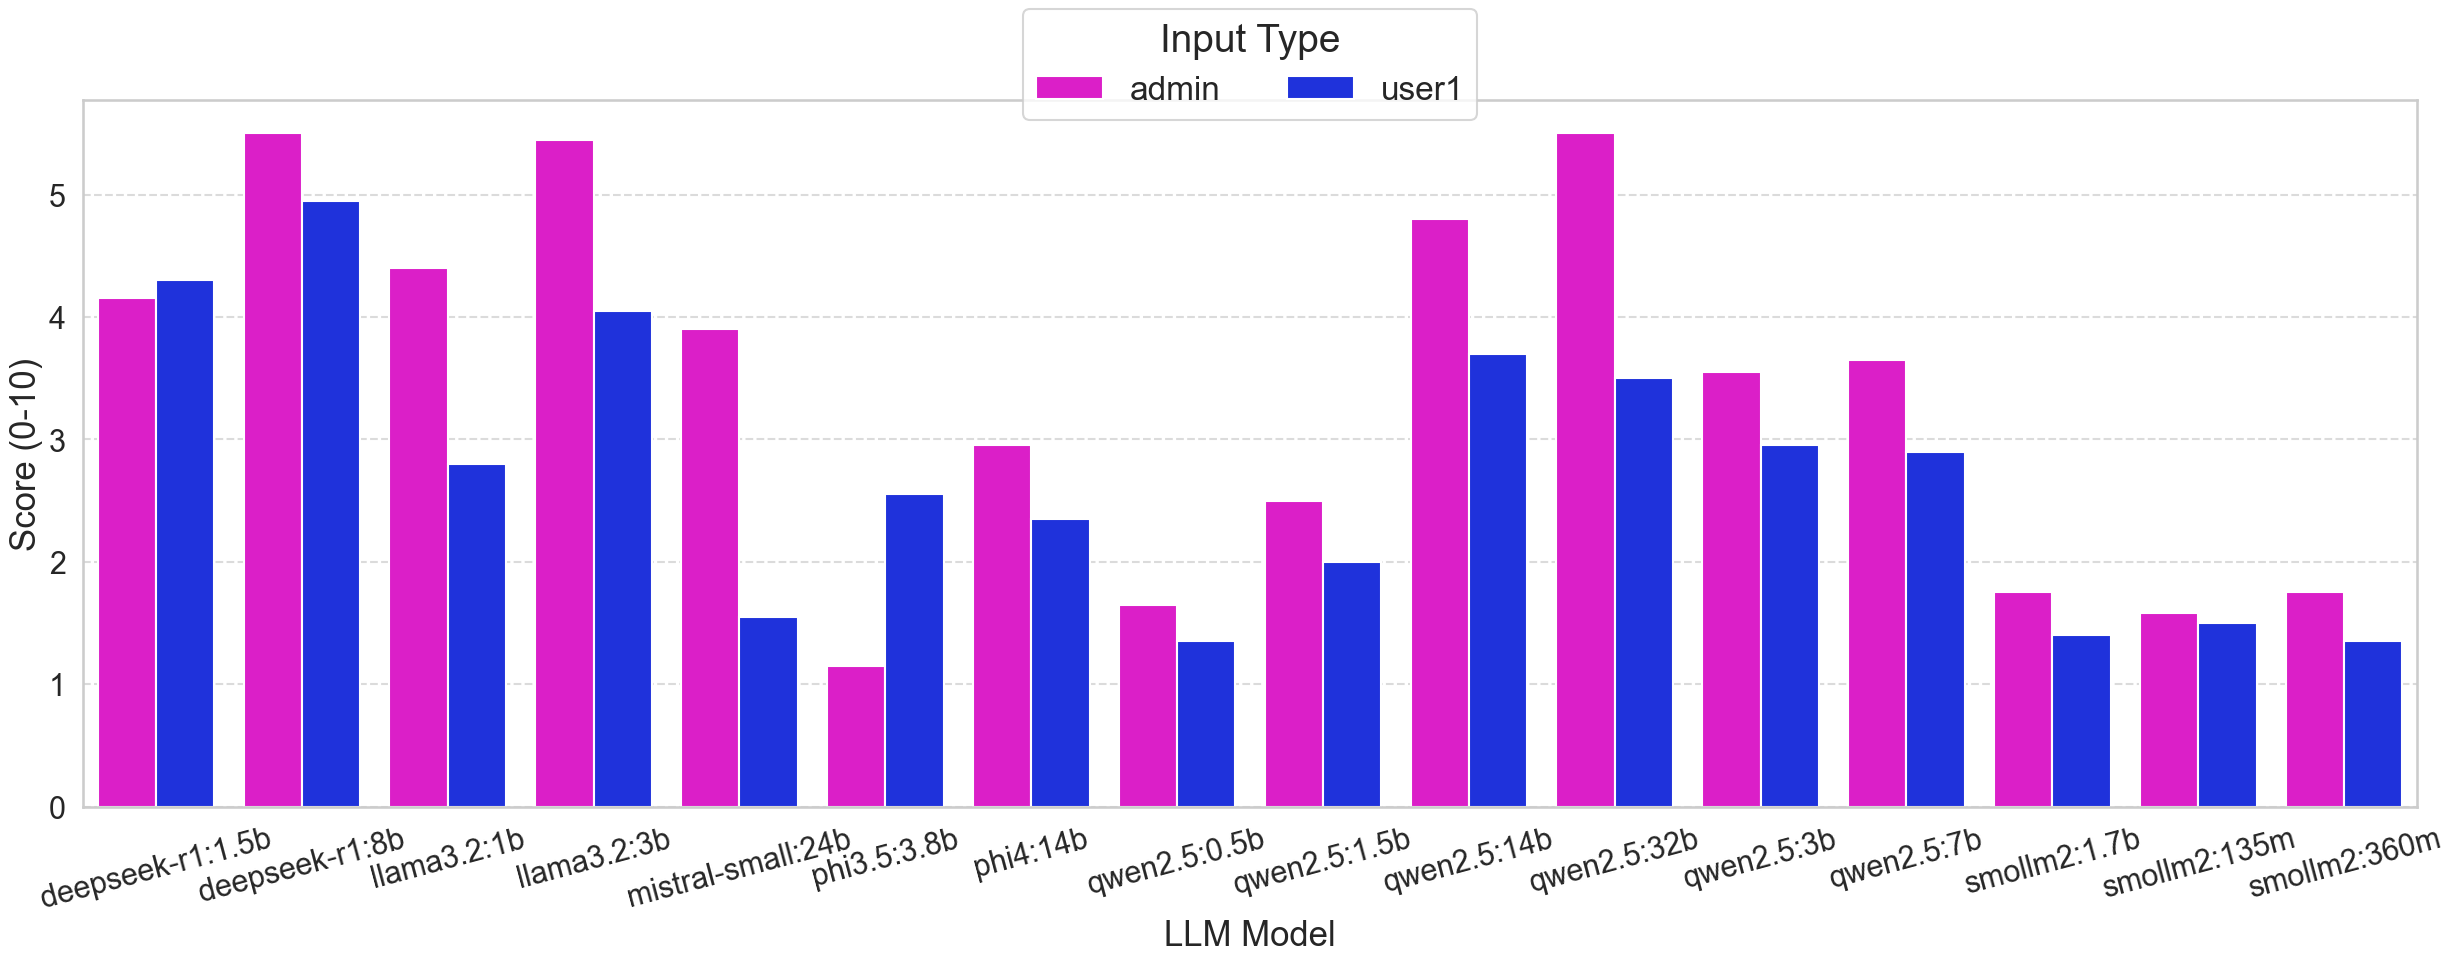

In [130]:
palette = config_seaborn()

# Create figure
plt.figure(figsize=(25, 10))

# Create grouped bar plot
ax = sns.barplot(
    data=access_model_df,
    x='model',
    y='score',
    hue='user',
    palette=palette
)

# Customize plot
# plt.title('Statistical Measures Across Embedding Models', pad=20, size=14)
plt.xlabel('LLM Model', size=25)
plt.ylabel('Score (0-10)', size=25)

# Rotate x-axis labels
plt.xticks(rotation=15, fontsize=22)
plt.yticks(fontsize=22)

# Adjust legend
plt.legend(
    title='Input Type',
    bbox_to_anchor=(0.5, 1.05),
    loc='center',
    ncol=4,
    frameon=True,
    fontsize=24,
    title_fontsize=28
)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# plt.savefig('./plots/model_performance.png', dpi=300)
# Show plot
plt.show()

/var/folders/m1/mg27xm293zg8r4pj5rd35m6r0000gn/T/ipykernel_53425/309705967.py:21: UserWarning:

The palette list has more values (17) than needed (5), which may not be intended.



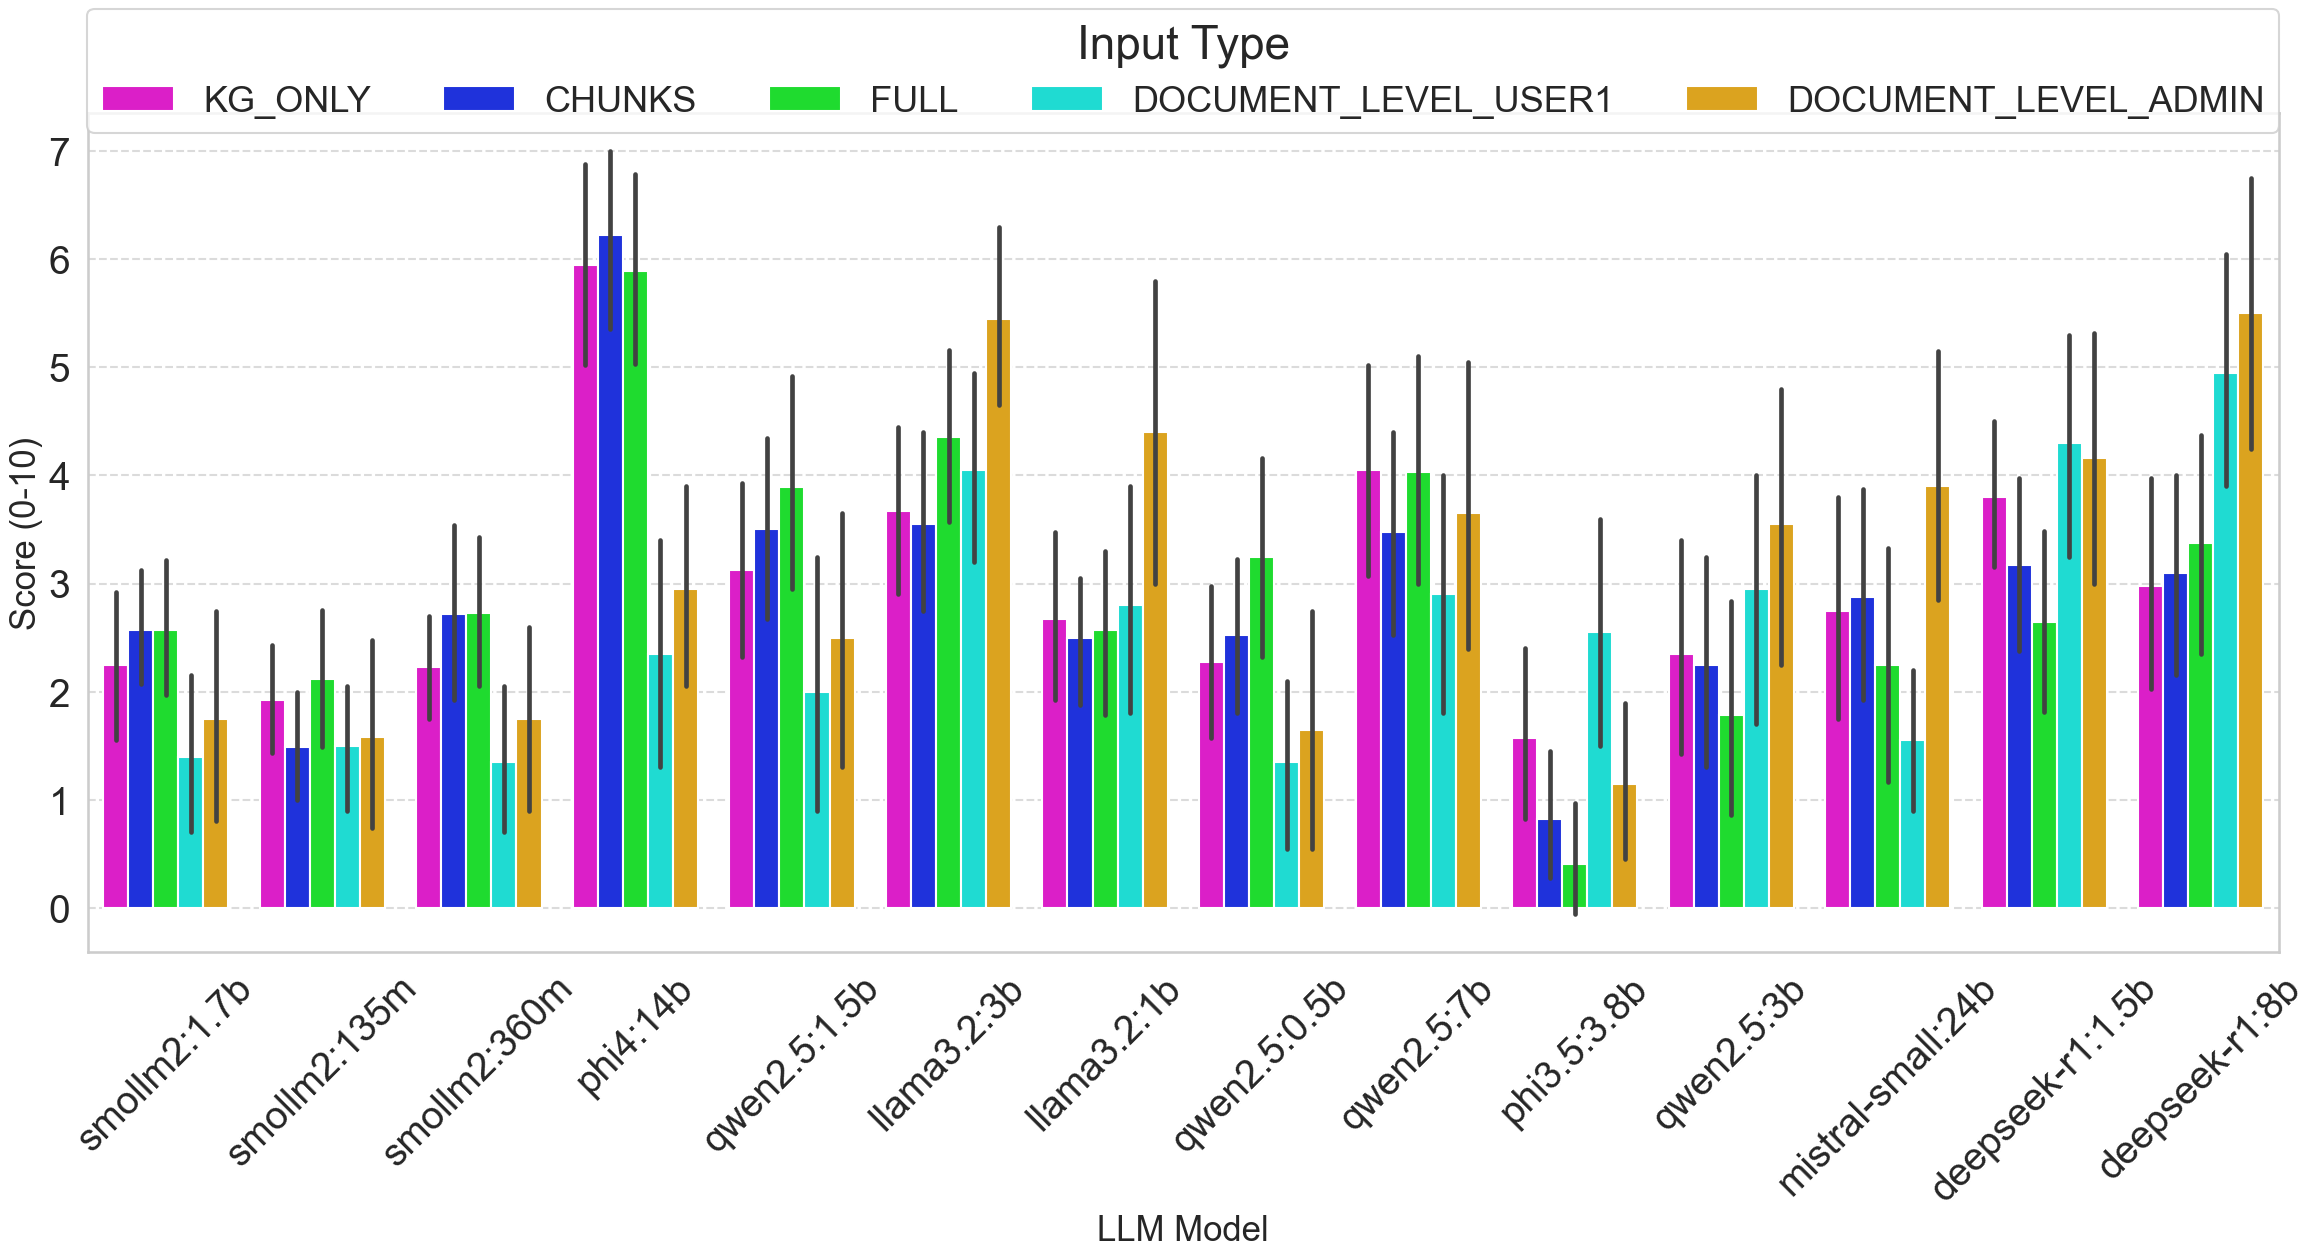

In [177]:
palette = config_seaborn()

# Create figure
plt.figure(figsize=(25, 13))

# Create grouped bar plot

models_to_drop = ['qwen2.5:32b', 'qwen2.5:14b']
_df = combined_df[~combined_df['model'].isin(models_to_drop)].copy()

# Create new access types based on user and access combination
def modify_access(row):
    if row['access'] == 'DOCUMENT_LEVEL':
        return f'DOCUMENT_LEVEL_{row["user"].upper()}'
    return row['access']

# Apply the modification to the DataFrame
_df['access'] = _df.apply(modify_access, axis=1)


ax = sns.barplot(
    data=_df,
    x='model',
    y='score',
    hue='access',
    palette=palette
)

# Customize plot
# plt.title('Statistical Measures Across Embedding Models', pad=20, size=14)
plt.xlabel('LLM Model', size=25)
plt.ylabel('Score (0-10)', size=25)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=28)
plt.yticks(fontsize=28)

# Adjust legend
plt.legend(
    title='Input Type',
    bbox_to_anchor=(0.5, 1.05),
    loc='center',
    ncol=5,
    frameon=True,
    fontsize=26,
    title_fontsize=33
)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

plt.savefig('./plots/model_performance.png', dpi=300)
# Show plot
plt.show()

In [172]:
_df.groupby('access')[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean().reset_index().sort_values(by='score', ascending=False)

,access,response_time,score,hallucination_score,answer_relevance,usefulness,context_precision,context_recall
1,DOCUMENT_LEVEL_ADMIN,1.899532,3.140288,0.791547,0.502698,0.468705,0.220144,0.237050
3,FULL,3.237160,2.996109,0.911187,0.461770,0.479961,0.168482,0.183852
4,KG_ONLY,3.182487,2.973166,0.898122,0.483631,0.500716,0.187478,0.196780
0,CHUNKS,3.157186,2.915771,0.910215,0.460753,0.483333,0.169176,0.182796
2,DOCUMENT_LEVEL_USER1,1.920286,2.571429,0.887857,0.404286,0.418571,0.143369,0.155357


In [171]:
_df[_df['user'] == 'user1'].groupby('access')[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean().reset_index().sort_values(by='score', ascending=False)

,access,response_time,score,hallucination_score,answer_relevance,usefulness,context_precision,context_recall
2,FULL,3.362076,3.135593,0.903814,0.460381,0.477119,0.167797,0.189407
3,KG_ONLY,3.105054,3.121864,0.904659,0.505376,0.523297,0.194982,0.205376
0,CHUNKS,3.085986,2.853047,0.893548,0.460036,0.477778,0.164875,0.183513
1,DOCUMENT_LEVEL_USER1,1.920286,2.571429,0.887857,0.404286,0.418571,0.143369,0.155357


/var/folders/m1/mg27xm293zg8r4pj5rd35m6r0000gn/T/ipykernel_53425/1039934944.py:15: UserWarning:

The palette list has more values (17) than needed (16), which may not be intended.



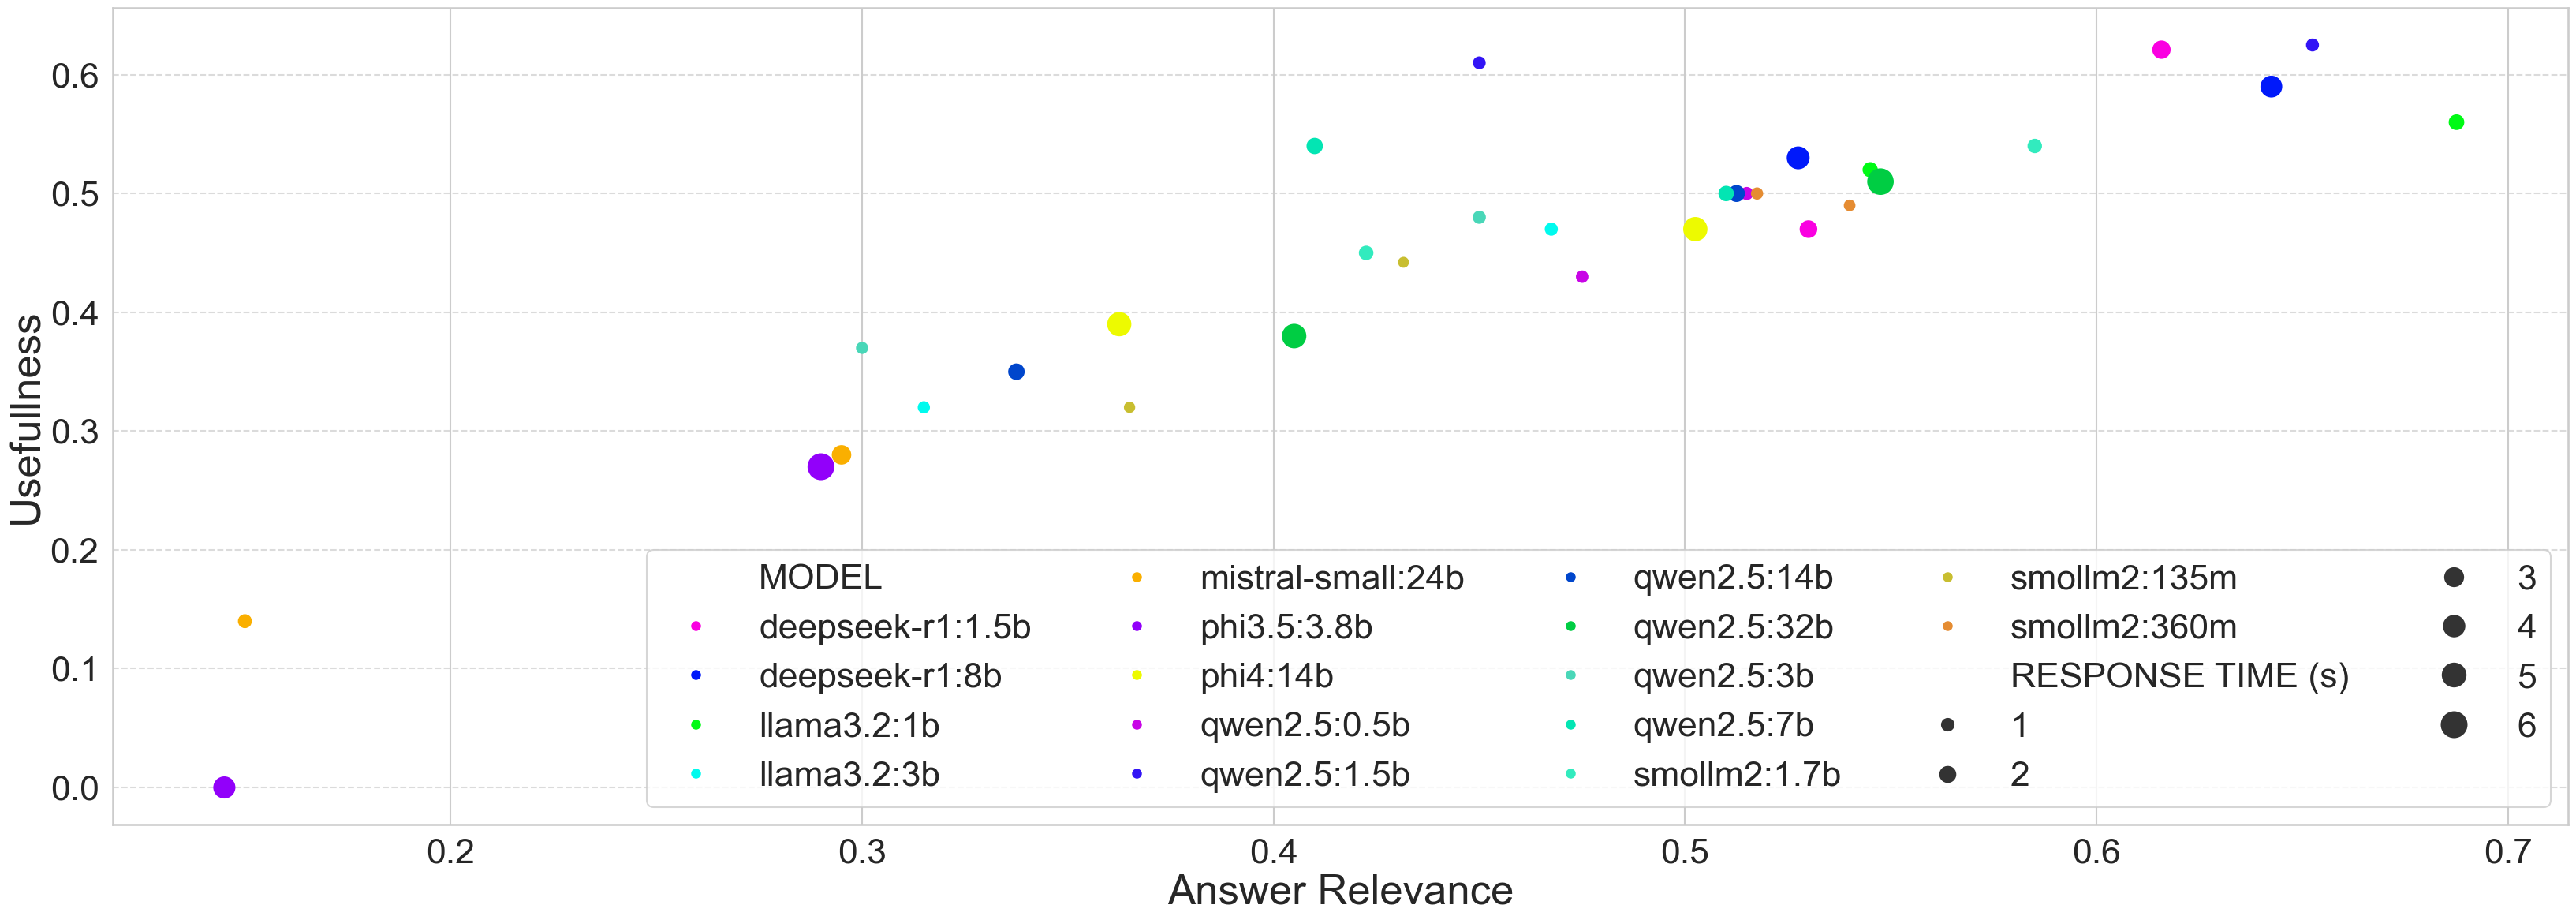

In [152]:
palette = config_seaborn()

scatter_df = final_df_opik.groupby(['model', 'access', 'user'])[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean().reset_index()
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

# Apply to a single column
scatter_df['normalized_response_time'] = min_max_scaling(scatter_df['response_time'])
# Create figure
plt.figure(figsize=(33, 12))

# Create grouped bar plot
ax = sns.scatterplot(
    x="answer_relevance", 
    y="usefulness",
    hue="model", 
    size="response_time",
    palette=palette,
    sizes=(100, 600), 
    linewidth=0,
    data=scatter_df, 
)

# Customize plot
# plt.title('Statistical Measures Across Embedding Models', pad=20, size=14)
plt.xlabel('Answer Relevance', size=38)
plt.ylabel('Usefullness', size=38)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

legend = plt.legend(
    ncol=5,
    fontsize=32,
)
legend.get_texts()[0].set_text('MODEL')
legend.get_texts()[17].set_text('RESPONSE TIME (s)')

plt.tick_params(axis='both', labelsize=32)

# Adjust layout
plt.tight_layout()

plt.savefig('./plots/model_relevance_usefulness_performance.png', dpi=300)
# Show plot
plt.show()

/var/folders/m1/mg27xm293zg8r4pj5rd35m6r0000gn/T/ipykernel_53425/4284130305.py:17: UserWarning:

The palette list has more values (17) than needed (16), which may not be intended.



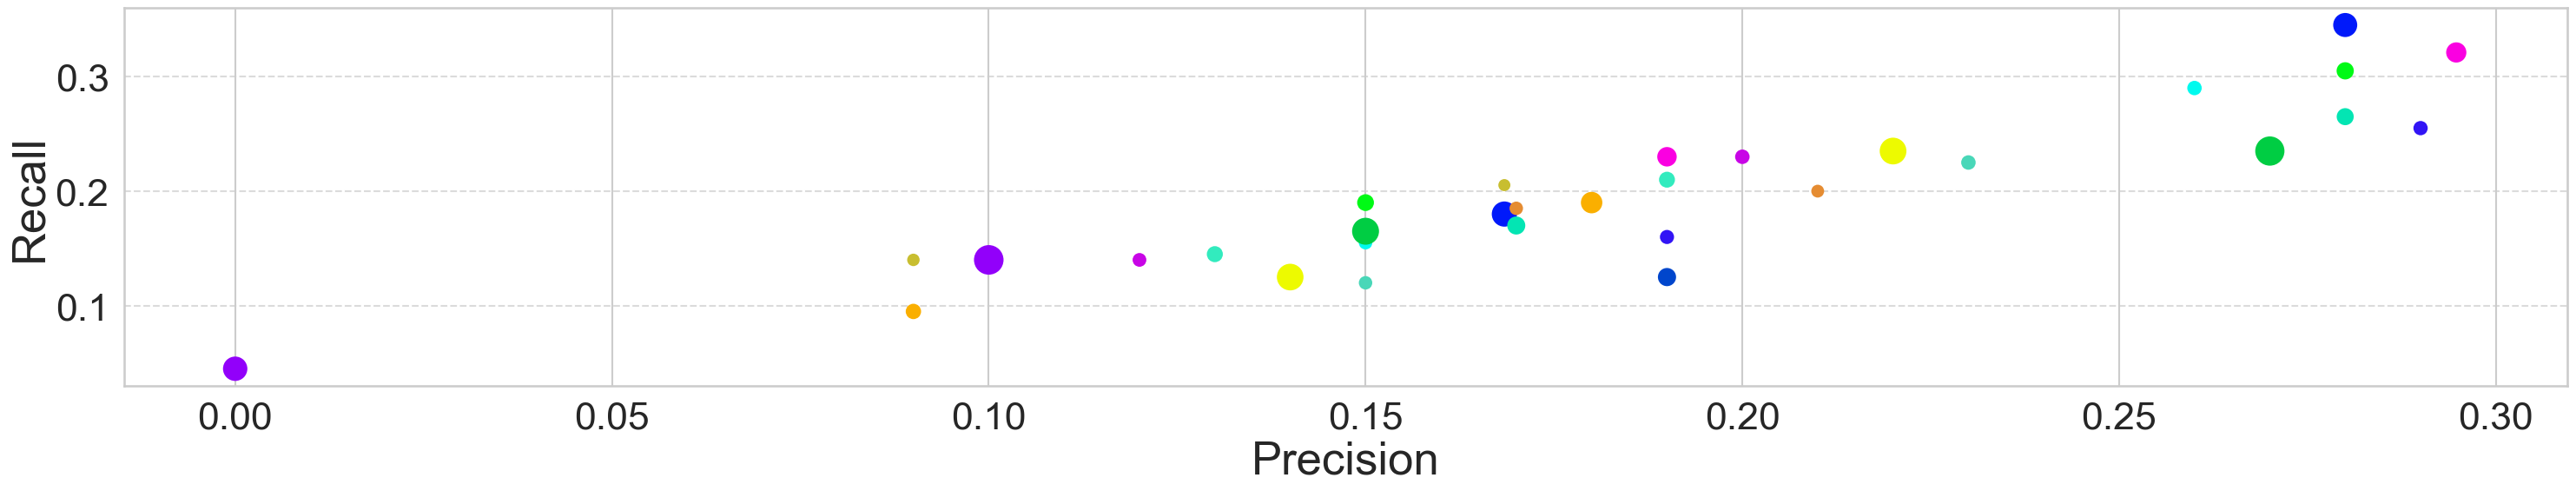

In [153]:
from matplotlib.patches import Rectangle

palette = config_seaborn()

scatter_df = final_df_opik.groupby(['model', 'access', 'user'])[['response_time', 'score', 'hallucination_score', 'answer_relevance', 'usefulness', 'context_precision', 'context_recall']].mean().reset_index()
# def min_max_scaling(column):
#     min_val = column.min()
#     max_val = column.max()
#     return (column - min_val) / (max_val - min_val)

# Apply to a single column
# scatter_df['normalized_response_time'] = min_max_scaling(scatter_df['response_time'])
# Create figure
plt.figure(figsize=(30,6))

# Create grouped bar plot
ax = sns.scatterplot(
    x="context_precision", 
    y="context_recall",
    hue="model", 
    size="response_time",
    palette=palette,
    sizes=(100, 600), 
    linewidth=0,
    data=scatter_df, 
)
# rect = Rectangle((7, 0.5), 3, 0.5, color='gray', alpha=0.5, transform=ax.transData)
# ax.add_patch(rect)
# ax.text(8.5, 0.75, 'better performance', color='black', fontsize=10, ha='center', va='center')

# Customize plot
# plt.title('Statistical Measures Across Embedding Models', pad=20, size=14)
plt.xlabel('Precision', size=38)
plt.ylabel('Recall', size=38)
plt.legend('', frameon=False)
plt.tick_params(axis='both', labelsize=32)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

plt.savefig('./plots/model_precision_recall_performance.png', dpi=300)
# Show plot
plt.show()

# Opik Metrics

In [20]:
pd.set_option("display.max_columns", None)
print(final_df_opik.columns)
final_df_opik.head(1)

Index(['model', 'access', 'user', 'question', 'response', 'answer',
       'reference', 'response_time', 'response_length', 'response_tokens',
       'qid', 'score', 'reasoning', 'meta_analysis', 'levenshtein_ratio',
       'levenshtein_ratio_reason', 'hallucination_score',
       'hallucination_score_reason', 'answer_relevance',
       'answer_relevance_reason', 'usefulness', 'usefulness_reason',
       'context_precision', 'context_precision_reason', 'context_recall',
       'context_recall_reason', 'score_normalized'],
      dtype='object')


,model,access,user,question,response,answer,reference,response_time,response_length,response_tokens,qid,score,reasoning,meta_analysis,levenshtein_ratio,levenshtein_ratio_reason,hallucination_score,hallucination_score_reason,answer_relevance,answer_relevance_reason,usefulness,usefulness_reason,context_precision,context_precision_reason,context_recall,context_recall_reason,score_normalized
0,deepseek-r1:8b,DOCUMENT_LEVEL,user1,Who is Apple's new Chief Financial Officer?,"<think>\nOkay, so I need to figure out who App...",Kevan Parekh,Apple's Board of Directors appointed Kevan Par...,2.99,1694,311,1,4.0,This response appropriately identifies that th...,The responses vary significantly in their accu...,"ScoreResult(name='levenshtein_ratio_metric', v...",NaN,1.0,"[""The OUTPUT incorrectly states that the infor...",0.3,The answer acknowledges the lack of specific i...,0.2,The AI response fails to answer the user's que...,0.0,The answer from the LLM does not provide any s...,0.1,The LLM's response fails to directly answer th...,0.4


In [21]:
# Calculate mean scores for each model
metrics_to_plot = ['hallucination_score', 'answer_relevance', 'usefulness', 
                  'context_precision', 'context_recall']

# Group by model and calculate means
model_metrics = final_df_opik.groupby('model')[metrics_to_plot].mean().round(3)

# Create radar chart using Plotly
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add traces for each model
for model in model_metrics.index:
    fig.add_trace(go.Scatterpolar(
        r=model_metrics.loc[model],
        theta=metrics_to_plot,
        name=model,
        fill='toself'
    ))

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]  # Scores are between 0 and 1
        )),
    showlegend=True,
    title="Model Performance Across Evaluation Metrics",
    width=800,
    height=600
)

# Show the plot
fig.show()

# Save the plot
# fig.write_html("./results/model_performance_radar.html")

In [ ]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(dict(
    r=[1, 5, 2, 2, 3],
    theta=['processing cost','mechanical properties','chemical stability',
           'thermal stability', 'device integration']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.show()

In [ ]:
palette = config_seaborn()

# Create figure
plt.figure(figsize=(25, 10))

# Create grouped bar plot
ax = sns.barplot(
    data=final_df_opik,
    x='model',
    y='score',
    hue='access',
    palette=palette
)

# Customize plot
# plt.title('Statistical Measures Across Embedding Models', pad=20, size=14)
plt.xlabel('LLM Model', size=25)
plt.ylabel('Score (0-10)', size=25)

# Rotate x-axis labels
plt.xticks(rotation=15, fontsize=22)
plt.yticks(fontsize=22)

# Adjust legend
plt.legend(
    title='IoU',
    bbox_to_anchor=(0.5, 1.05),
    loc='center',
    ncol=4,
    frameon=True,
    fontsize=24,
    title_fontsize=28
)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# plt.savefig('./plots/model_performance.png', dpi=300)
# Show plot
plt.show()

# Embeddings

In [194]:
import ollama
import numpy as np

def get_embeddings(text: str) -> List[float]:
    """
    Get embeddings for text using ollama's all-minilm model.
    
    Args:
        text: Text to embed
        
    Returns:
        List[float]: Embedding vector
    """
    response = ollama.embeddings(
        model='all-minilm:33m',
        prompt=text
    )
    return response['embedding']

def create_embeddings_dataframe() -> pd.DataFrame:
    """
    Create a DataFrame containing embeddings for all LLM responses along with metadata.
    
    Returns:
        pd.DataFrame: DataFrame with columns for model name, filename, and embedding values
    """
    # Get file structure
    output_structure = get_llm_output_structure()
    
    # Lists to store data
    data = []
    
    # Process each file
    for model_name, files in output_structure.items():
        for file_name in files:
            try:
                # Read content
                content = read_llm_response(file_name)
                
                # Get embeddings
                embedding = get_embeddings(content)
                
                # Store data
                data.append({
                    'model': model_name,
                    'filename': file_name.split('/')[-1],  # Just the filename without path
                    'embedding': embedding
                })
                
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Expand embedding column into separate columns
    embedding_df = pd.DataFrame(df['embedding'].tolist(), 
                              columns=[f'dim_{i}' for i in range(len(df['embedding'].iloc[0]))])
    
    # Combine metadata with embeddings
    result_df = pd.concat([
        df[['model', 'filename']],
        embedding_df
    ], axis=1)
    
    return result_df

# Create and display the DataFrame
embeddings_df = create_embeddings_dataframe()
print("\nDataFrame Shape:", embeddings_df.shape)
# print("\nFirst few rows:")
# print(embeddings_df.head())

# Optionally save to parquet for later use
embeddings_df.to_parquet('./results/response_embeddings.parquet')
embeddings_df.head()


DataFrame Shape: (400, 386)


,model,filename,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_374,dim_375,dim_376,dim_377,dim_378,dim_379,dim_380,dim_381,dim_382,dim_383
0,qwen2.5_7b,CHUNKS_admin_0_1.txt,-0.075566,0.119131,-0.036106,-0.095838,-0.049041,0.003664,-0.127176,0.092244,...,-0.113079,0.008026,0.111015,-0.082428,0.148435,-0.000946,0.015064,0.055559,-0.129441,0.107625
1,qwen2.5_7b,CHUNKS_admin_1_1.txt,-0.008544,-0.101055,-0.130910,-0.054039,0.110466,-0.068998,-0.068796,0.039880,...,0.184230,0.196043,0.064503,-0.083653,-0.010190,0.024736,0.163483,0.089139,-0.094404,-0.092834
2,qwen2.5_7b,CHUNKS_admin_2_1.txt,0.025271,-0.199228,0.005019,0.219409,0.082700,-0.117323,-0.105174,0.076461,...,0.116590,0.017078,-0.158439,-0.036856,-0.027145,0.094577,-0.118003,-0.053782,-0.151496,0.009665
3,qwen2.5_7b,CHUNKS_admin_3_1.txt,0.070269,0.026260,-0.095843,0.056919,0.190134,-0.027714,-0.125104,0.045174,...,0.095337,0.170429,0.162762,-0.050768,-0.128579,0.012660,-0.079618,0.123970,-0.122808,-0.058790
4,qwen2.5_7b,CHUNKS_admin_4_1.txt,0.073119,-0.056663,-0.111264,-0.087591,0.004742,-0.318034,-0.320232,-0.027044,...,0.121301,0.161043,-0.056585,0.054711,0.090903,0.069179,0.044614,-0.135994,0.010154,-0.005580


# Visualization

In [195]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.graph_objects as go

def create_reduced_dim_plots(df: pd.DataFrame, method: str = 'pca', n_components: int = 2) -> go.Figure:
    """
    Create dimensionality reduction plots using either PCA or t-SNE.
    
    Args:
        df: DataFrame containing embeddings and metadata
        method: Reduction method ('pca' or 'tsne')
        n_components: Number of components for reduction
        
    Returns:
        go.Figure: Interactive plotly figure
    """
    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('dim_')]
    
    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        explained_var = reducer.explained_variance_ratio_
        title = f'PCA Visualization (Explained variance: {sum(explained_var):.2%})'
    else:  # t-SNE
        reducer = TSNE(n_components=n_components, random_state=42)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        title = 'T-SNE Visualization'
    
    # Create DataFrame with reduced dimensions
    plot_df = pd.DataFrame(
        reduced_data,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Add metadata
    plot_df['model'] = df['model']
    plot_df['filename'] = df['filename']
    
    # Extract type from filename (CHUNKS, DOCUMENT_LEVEL, etc.)
    plot_df['response_type'] = plot_df['filename'].apply(lambda x: x.split('_')[0])
    
    # Create hover text
    plot_df['hover_text'] = plot_df.apply(
        lambda row: f"Model: {row['model']}<br>File: {row['filename']}<br>Type: {row['response_type']}", 
        axis=1
    )
    
    # Create figure
    fig = px.scatter(
        plot_df,
        x='Component_1',
        y='Component_2',
        color='model',
        symbol='response_type',
        hover_data=['filename'],
        title=title,
        labels={
            'Component_1': f'{method.upper()} Component 1',
            'Component_2': f'{method.upper()} Component 2'
        }
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    return fig

In [196]:
# Create both visualizations
pca_fig = create_reduced_dim_plots(embeddings_df, method='pca')
tsne_fig = create_reduced_dim_plots(embeddings_df, method='tsne')

# Display figures
# pca_fig.show()
# tsne_fig.show()

# Optionally save the figures
pca_fig.write_html("./results/pca_visualization.html")
tsne_fig.write_html("./results/tsne_visualization.html")

## Response depended

In [197]:
def create_reduced_dim_plots_by_type(df: pd.DataFrame, method: str = 'pca', n_components: int = 2) -> Dict[str, go.Figure]:
    """
    Create separate dimensionality reduction plots for each response type.
    
    Args:
        df: DataFrame containing embeddings and metadata
        method: Reduction method ('pca' or 'tsne')
        n_components: Number of components for reduction
        
    Returns:
        Dict[str, go.Figure]: Dictionary mapping response types to their figures
    """
    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('dim_')]
    
    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        explained_var = reducer.explained_variance_ratio_
        title_prefix = f'PCA Visualization (Explained variance: {sum(explained_var):.2%})'
    else:  # t-SNE
        reducer = TSNE(n_components=n_components, random_state=42)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        title_prefix = 'T-SNE Visualization'
    
    # Create DataFrame with reduced dimensions
    plot_df = pd.DataFrame(
        reduced_data,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Add metadata
    plot_df['model'] = df['model']
    plot_df['filename'] = df['filename']
    plot_df['response_type'] = df['filename'].apply(lambda x: x.split('_')[0])
    
    # Create hover text
    plot_df['hover_text'] = plot_df.apply(
        lambda row: f"Model: {row['model']}<br>File: {row['filename']}", 
        axis=1
    )
    
    # Create separate figures for each response type
    figures = {}
    for response_type in plot_df['response_type'].unique():
        type_df = plot_df[plot_df['response_type'] == response_type]
        
        fig = px.scatter(
            type_df,
            x='Component_1',
            y='Component_2',
            color='model',
            hover_data=['filename'],
            title=f"{title_prefix} - {response_type}",
            labels={
                'Component_1': f'{method.upper()} Component 1',
                'Component_2': f'{method.upper()} Component 2'
            }
        )
        
        # Update layout
        fig.update_layout(
            height=600,
            width=800,
            template='plotly_white',
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )
        
        figures[response_type] = fig
    
    return figures

# Create visualizations for both PCA and t-SNE
pca_figs = create_reduced_dim_plots_by_type(embeddings_df, method='pca')
tsne_figs = create_reduced_dim_plots_by_type(embeddings_df, method='tsne')

In [198]:
# Display all figures
# print("\nPCA Visualizations:")
# for response_type, fig in pca_figs.items():
#     print(f"\n{response_type}:")
#     fig.show()
    
# print("\nT-SNE Visualizations:")
# for response_type, fig in tsne_figs.items():
#     print(f"\n{response_type}:")
#     fig.show()

# Save all figures
for response_type, fig in pca_figs.items():
    fig.write_html(f"./results/pca_visualization_{response_type.lower()}.html")
    
for response_type, fig in tsne_figs.items():
    fig.write_html(f"./results/tsne_visualization_{response_type.lower()}.html")

## Similarity

In [199]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def create_similarity_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a DataFrame containing cosine similarities between all embeddings.
    
    Args:
        df: DataFrame containing embeddings and metadata
        
    Returns:
        pd.DataFrame: DataFrame with cosine similarities and metadata
    """
    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('dim_')]
    
    # Calculate cosine similarity matrix
    similarities = cosine_similarity(df[embedding_cols])
    
    # Create identifiers for each row
    identifiers = df.apply(
        lambda row: f"{row['model']} - {row['filename']}", 
        axis=1
    ).values
    
    # Create similarity DataFrame with identifiers
    similarity_df = pd.DataFrame(
        similarities,
        index=identifiers,
        columns=identifiers
    )
    
    return similarity_df

# Create similarity matrix
similarity_df = create_similarity_matrix(embeddings_df)

# Display sample of the matrix
print("\nSimilarity Matrix Shape:", similarity_df.shape)
# print("\nSample of Similarity Matrix:")
# print(similarity_df.iloc[:5, :5])

# Save to parquet
similarity_df.to_parquet('./results/response_similarities.parquet')

# Optional: Find most similar pairs (excluding self-similarity)
def get_top_similarities(sim_df: pd.DataFrame, n: int = 10) -> pd.DataFrame:
    """
    Get the top N most similar pairs of responses.
    
    Args:
        sim_df: Similarity matrix DataFrame
        n: Number of top pairs to return
        
    Returns:
        pd.DataFrame: DataFrame with top similar pairs
    """
    # Create pairs DataFrame
    pairs = []
    for i in range(len(sim_df)):
        for j in range(i + 1, len(sim_df)):  # Only upper triangle to avoid duplicates
            pairs.append({
                'response1': sim_df.index[i],
                'response2': sim_df.index[j],
                'similarity': sim_df.iloc[i, j]
            })
    
    pairs_df = pd.DataFrame(pairs)
    return pairs_df.nlargest(n, 'similarity')

# Get top similar pairs
top_pairs = get_top_similarities(similarity_df, n=20)
print("\nTop 20 Most Similar Pairs:")
top_pairs.head()


Similarity Matrix Shape: (400, 400)

Top 20 Most Similar Pairs:


,response1,response2,similarity
77918,deepseek-r1_32b - CHUNKS_user1_8_1.txt,deepseek-r1_32b - DOCUMENT_LEVEL_admin_8_1.txt,1.0
77938,deepseek-r1_32b - CHUNKS_user1_8_1.txt,deepseek-r1_32b - FULL_admin_8_1.txt,1.0
77958,deepseek-r1_32b - CHUNKS_user1_8_1.txt,deepseek-r1_32b - KG_ONLY_admin_8_1.txt,1.0
78493,deepseek-r1_32b - DOCUMENT_LEVEL_admin_8_1.txt,deepseek-r1_32b - FULL_admin_8_1.txt,1.0
78513,deepseek-r1_32b - DOCUMENT_LEVEL_admin_8_1.txt,deepseek-r1_32b - KG_ONLY_admin_8_1.txt,1.0


In [200]:
def create_similarity_pairs_df(similarity_df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform similarity matrix into a long-format DataFrame with paired responses.
    
    Args:
        similarity_df: DataFrame containing similarity matrix
        
    Returns:
        pd.DataFrame: Long-format DataFrame with columns for response pairs and their similarity
    """
    # Create empty lists to store the data
    pairs = []
    
    # Iterate through upper triangle of matrix (excluding diagonal)
    for i in range(len(similarity_df)):
        for j in range(i + 1, len(similarity_df)):
            # Get response identifiers
            response1 = similarity_df.index[i]
            response2 = similarity_df.columns[j]
            
            # Split identifiers into model and filename
            response1_model, response1_filename = response1.split(" - ", 1)
            response2_model, response2_filename = response2.split(" - ", 1)
            
            # Get similarity score
            similarity = similarity_df.iloc[i, j]
            
            # Add to pairs list
            pairs.append({
                'response_1_model': response1_model,
                'response_1_filename': response1_filename,
                'response_2_model': response2_model,
                'response_2_filename': response2_filename,
                'similarity': similarity
            })
    
    # Create DataFrame from pairs
    pairs_df = pd.DataFrame(pairs)
    
    # Sort by similarity in descending order
    pairs_df = pairs_df.sort_values('similarity', ascending=False)
    
    return pairs_df

# Create the transformed DataFrame
similarity_pairs_df = create_similarity_pairs_df(similarity_df)

# Display sample and save
print("\nShape of transformed DataFrame:", similarity_pairs_df.shape)
print("\nSample of highest similarity pairs:")
# print(similarity_pairs_df.head())

# Save to CSV
similarity_pairs_df.to_csv('./results/response_similarity_pairs.csv', index=False)
similarity_pairs_df


Shape of transformed DataFrame: (79800, 5)

Sample of highest similarity pairs:


,response_1_model,response_1_filename,response_2_model,response_2_filename,similarity
77958,deepseek-r1_32b,CHUNKS_user1_8_1.txt,deepseek-r1_32b,KG_ONLY_admin_8_1.txt,1.000000
77938,deepseek-r1_32b,CHUNKS_user1_8_1.txt,deepseek-r1_32b,FULL_admin_8_1.txt,1.000000
78493,deepseek-r1_32b,DOCUMENT_LEVEL_admin_8_1.txt,deepseek-r1_32b,FULL_admin_8_1.txt,1.000000
79323,deepseek-r1_32b,FULL_admin_8_1.txt,deepseek-r1_32b,KG_ONLY_admin_8_1.txt,1.000000
77918,deepseek-r1_32b,CHUNKS_user1_8_1.txt,deepseek-r1_32b,DOCUMENT_LEVEL_admin_8_1.txt,1.000000
...,...,...,...,...,...
36304,mistral-small_24b,DOCUMENT_LEVEL_admin_4_1.txt,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,-0.104718
44689,mistral-small_24b,FULL_user1_4_1.txt,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,-0.105722
71369,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,deepseek-r1_32b,DOCUMENT_LEVEL_user1_4_1.txt,-0.111688
71349,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,deepseek-r1_32b,CHUNKS_user1_4_1.txt,-0.113390


## Inter-Model Consistency Analysis:

In [201]:
def analyze_model_consistency(similarity_pairs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze how consistent each model's responses are with itself and other models.
    
    Args:
        similarity_pairs_df: DataFrame with similarity pairs
        
    Returns:
        pd.DataFrame: Statistics about model consistency
    """
    # Self-consistency (how similar are responses from the same model)
    self_consistency = similarity_pairs_df[
        similarity_pairs_df['response_1_model'] == similarity_pairs_df['response_2_model']
    ].groupby('response_1_model')['similarity'].agg(['mean', 'std']).round(4)
    
    # Cross-model agreement
    cross_model = similarity_pairs_df[
        similarity_pairs_df['response_1_model'] != similarity_pairs_df['response_2_model']
    ].groupby(['response_1_model', 'response_2_model'])['similarity'].mean().round(4)
    
    return self_consistency, cross_model

# Get consistency metrics
self_consistency, cross_model = analyze_model_consistency(similarity_pairs_df)
print("\nModel Self-Consistency:")
print(self_consistency)
print("\nCross-Model Agreement:")
cross_model.reset_index()


Model Self-Consistency:
                     mean     std
response_1_model                 
deepseek-r1_1.5b   0.3150  0.1793
deepseek-r1_32b    0.3404  0.2116
mistral-small_24b  0.3323  0.2014
qwen2.5_3b         0.3372  0.1766
qwen2.5_7b         0.3594  0.1810

Cross-Model Agreement:


,response_1_model,response_2_model,similarity
0,deepseek-r1_1.5b,deepseek-r1_32b,0.3237
1,mistral-small_24b,deepseek-r1_1.5b,0.3207
2,mistral-small_24b,deepseek-r1_32b,0.3354
3,mistral-small_24b,qwen2.5_3b,0.3314
4,qwen2.5_3b,deepseek-r1_1.5b,0.3213
5,qwen2.5_3b,deepseek-r1_32b,0.3321
6,qwen2.5_7b,deepseek-r1_1.5b,0.3329
7,qwen2.5_7b,deepseek-r1_32b,0.3440
8,qwen2.5_7b,mistral-small_24b,0.3424
9,qwen2.5_7b,qwen2.5_3b,0.3516


## Response Type Analysis:

In [202]:
def analyze_response_types(similarity_pairs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze how different response types (CHUNKS, DOCUMENT_LEVEL, etc.) compare.
    
    Args:
        similarity_pairs_df: DataFrame with similarity pairs
        
    Returns:
        pd.DataFrame: Statistics about response type consistency
    """
    # Extract response types
    similarity_pairs_df['response_1_type'] = similarity_pairs_df['response_1_filename'].apply(
        lambda x: x.split('_')[0]
    )
    similarity_pairs_df['response_2_type'] = similarity_pairs_df['response_2_filename'].apply(
        lambda x: x.split('_')[0]
    )
    
    # Analyze consistency within and between response types
    type_analysis = similarity_pairs_df.groupby(
        ['response_1_type', 'response_2_type', 'response_1_model']
    )['similarity'].agg(['mean', 'std', 'count']).round(4)
    
    return type_analysis

# Get response type analysis
type_analysis = analyze_response_types(similarity_pairs_df)
print("\nResponse Type Analysis:")
type_analysis.reset_index()


Response Type Analysis:


,response_1_type,response_2_type,response_1_model,mean,std,count
0,CHUNKS,CHUNKS,deepseek-r1_1.5b,0.3347,0.1890,590
1,CHUNKS,CHUNKS,deepseek-r1_32b,0.3286,0.1938,190
2,CHUNKS,CHUNKS,mistral-small_24b,0.3438,0.1876,1390
3,CHUNKS,CHUNKS,qwen2.5_3b,0.3424,0.1817,990
4,CHUNKS,CHUNKS,qwen2.5_7b,0.3507,0.1831,1790
...,...,...,...,...,...,...
69,KG,KG,deepseek-r1_1.5b,0.3106,0.1896,590
70,KG,KG,deepseek-r1_32b,0.3039,0.2045,190
71,KG,KG,mistral-small_24b,0.3385,0.1820,1390
72,KG,KG,qwen2.5_3b,0.3204,0.1673,990


## Question-Level Analysis:

In [203]:
def analyze_question_responses(similarity_pairs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compare how different models answered the same questions.
    
    Args:
        similarity_pairs_df: DataFrame with similarity pairs
        
    Returns:
        pd.DataFrame: Question-level analysis
    """
    # Extract question numbers
    similarity_pairs_df['question_1'] = similarity_pairs_df['response_1_filename'].apply(
        lambda x: '_'.join(x.split('_')[1:3])  # Gets e.g., 'admin_1'
    )
    similarity_pairs_df['question_2'] = similarity_pairs_df['response_2_filename'].apply(
        lambda x: '_'.join(x.split('_')[1:3])
    )
    
    # Analyze same-question responses across models
    question_analysis = similarity_pairs_df[
        similarity_pairs_df['question_1'] == similarity_pairs_df['question_2']
    ].groupby(['question_1', 'response_1_model', 'response_2_model'])['similarity'].mean().round(4)
    
    return question_analysis

# Get question-level analysis
question_analysis = analyze_question_responses(similarity_pairs_df)
print("\nQuestion-Level Analysis:")
question_analysis.reset_index()


Question-Level Analysis:


,question_1,response_1_model,response_2_model,similarity
0,LEVEL_admin,deepseek-r1_1.5b,deepseek-r1_1.5b,0.2607
1,LEVEL_admin,deepseek-r1_1.5b,deepseek-r1_32b,0.3230
2,LEVEL_admin,deepseek-r1_32b,deepseek-r1_32b,0.3077
3,LEVEL_admin,mistral-small_24b,deepseek-r1_1.5b,0.3051
4,LEVEL_admin,mistral-small_24b,deepseek-r1_32b,0.3368
...,...,...,...,...
355,user1_9,qwen2.5_7b,deepseek-r1_1.5b,0.8276
356,user1_9,qwen2.5_7b,deepseek-r1_32b,0.8747
357,user1_9,qwen2.5_7b,mistral-small_24b,0.8329
358,user1_9,qwen2.5_7b,qwen2.5_3b,0.7939


## Viz

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_comparisons(similarity_pairs_df: pd.DataFrame):
    """
    Create heatmap visualizations of model similarities.
    """
    # Create model similarity matrix
    model_similarities = similarity_pairs_df.groupby(
        ['response_1_model', 'response_2_model']
    )['similarity'].mean().unstack()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        model_similarities, 
        annot=True, 
        cmap='magma',
        center=0,
        fmt='.3f'
    )
    plt.title('Average Response Similarity Between Models')
    plt.tight_layout()
    plt.savefig('./results/model_similarities_heatmap.png')
    plt.close()

# Create visualization
plot_model_comparisons(similarity_pairs_df)